<a href="https://colab.research.google.com/github/JsantosAn/Mestrado/blob/main/Atividade5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [244]:
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
from sklearn.model_selection import cross_validate
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
iris = load_iris()
X, y = iris.data[:,2:], iris.target


Base ires 

In [245]:

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i,k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

ytmp = y[:]
valor = impureza(ytmp)
valor
def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores
impurezaValor(X[:,0], y, 2.5)   

def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)
    while True:
     
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza
melhorValor(X[:,0], y)


def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]
print(melhorCaracteristica(X,y))

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]
    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.show()




(0, 2.475, 0.3333333333333333)


In [ ]:
class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

Nova Heuristica

In [247]:
def new_melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    #x = np.sort(x)
    valor = np.var(x)   

    while True:
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMaiores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
     
    return result, menorImpureza
new_melhorValor(X[:,0], y)


def new_melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = new_melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]
    print(new_melhorCaracteristica(X,y))


In [248]:
class New_arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = new_melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores)>0 and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)
    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = New_arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

In [ ]:
plotDecisao(New_arvore(), X, y)

Sklearn Arvore

In [249]:

sklearn_arvore = DecisionTreeClassifier()

sklearn_arvore.fit(X,y)
ypred = sklearn_arvore.predict(X)
accuracy_score(y, ypred), (ypred == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

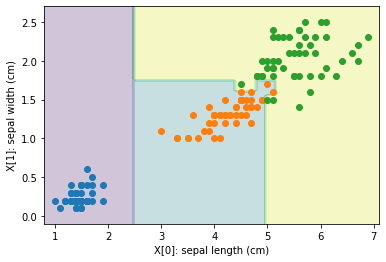

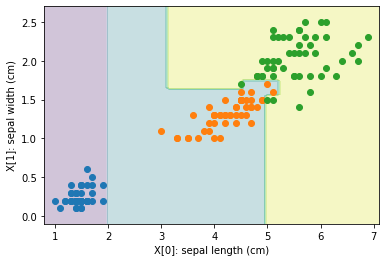

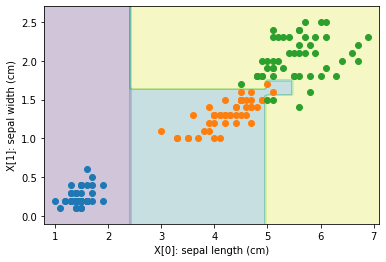

In [250]:
plotDecisao(Arvore(), X, y)
plotDecisao(New_arvore(), X, y)
plotDecisao(sklearn_arvore, X, y)

In [264]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00537/sobar-72.csv'
base = pd.read_csv(url) 
X, y = base.iloc[:,:-1], base.iloc[:,-1]
X = pd.DataFrame.to_numpy(X)
y = pd.DataFrame.to_numpy(y)   
print('###################################################################') 
print('conjunto de dados de risco de comportamento de câncer cervical  ')
print('###################################################################') 
modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
scores = cross_validate(Arvore(), X, y)
print('___________________________________________________________________') 
print('Arvore_video :' , np.mean(scores['test_score']))


modelo1 = New_arvore()
modelo1.fit(X,y)
ypred = modelo1.predict(X)
scores = cross_validate(New_arvore(), X, y)
print('Nova_Arvore :' , np.mean(scores['test_score']))




modelo2 = DecisionTreeClassifier()
modelo2.fit(X,y)
ypred = modelo2.predict(X)
scores = cross_validate(DecisionTreeClassifier(), X, y)
print('sklearn_arvore :' , np.mean(scores['test_score']))
print('___________________________________________________________________')

###################################################################
conjunto de dados de risco de comportamento de câncer cervical  
###################################################################
___________________________________________________________________
Arvore_video : 0.821904761904762
Nova_Arvore : 0.7923809523809524
sklearn_arvore : 0.8352380952380951
___________________________________________________________________


In [265]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00429/Cryotherapy.xlsx'
base = pd.read_excel(url) 
X, y = base.iloc[:,:-1], base.iloc[:,-1]
X = pd.DataFrame.to_numpy(X)
y = pd.DataFrame.to_numpy(y)   

print('###################################################################') 
print('conjunto de dados de crioterapia ')
print('###################################################################') 
modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
scores = cross_validate(Arvore(), X, y)  
print('___________________________________________________________________')   
print('Arvore_video :' , np.mean(scores['test_score']))


modelo1 = New_arvore()
modelo1.fit(X,y)
ypred = modelo1.predict(X)
scores = cross_validate(New_arvore(), X, y)
print('Nova_Arvore :' , np.mean(scores['test_score']))




modelo2 = DecisionTreeClassifier()
modelo2.fit(X,y)
ypred = modelo2.predict(X)
scores = cross_validate(DecisionTreeClassifier(), X, y)
print('sklearn_arvore :' , np.mean(scores['test_score']))
print('___________________________________________________________________')   






###################################################################
conjunto de dados de crioterapia 
###################################################################
___________________________________________________________________
Arvore_video : 0.8777777777777779
Nova_Arvore : 0.9
sklearn_arvore : 0.888888888888889
___________________________________________________________________


In [266]:
url =  'https://archive.ics.uci.edu/ml/machine-learning-databases/00428/Immunotherapy.xlsx'
base = pd.read_excel(url) 
X, y = base.iloc[:,:-1].values, base.iloc[:,-1].values

print('###################################################################') 
print('conjunto de dados de imunoterapia ')
print('###################################################################') 
modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)
scores = cross_validate(Arvore(), X, y)
print('___________________________________________________________________')
print('Arvore_video :' , np.mean(scores['test_score']))


modelo1 = New_arvore()
modelo1.fit(X,y)
ypred = modelo1.predict(X)
scores = cross_validate(New_arvore(), X, y)
print('Nova_Arvore :' , np.mean(scores['test_score']))




modelo2 = DecisionTreeClassifier()
modelo2.fit(X,y)
ypred = modelo2.predict(X)
scores = cross_validate(DecisionTreeClassifier(), X, y)
print('sklearn_arvore :' , np.mean(scores['test_score']))
print('___________________________________________________________________')







###################################################################
conjunto de dados de imunoterapia 
###################################################################
___________________________________________________________________
Arvore_video : 0.7222222222222221
Nova_Arvore : 0.8
sklearn_arvore : 0.8333333333333334
___________________________________________________________________


considerando oque foi proposto pela atividade utilizei da Variância como heuristica para montar a nova arvore de decisão os resultados não ficaram muito distantes dos algoritmos apresentados no video e o do sklearn, talvez eu possa ter interpretado mal a prosta. Mais os resultados se mostra bem satisfatorio